In [1]:
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import sys
import glob
import json
import numpy as np
from tqdm import tqdm
sys.path.append("../")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import glob
import os
import pandas as pd

def get_npy_files(root_path):
    # Use a glob pattern to match all .npz files in the directory and subdirectories
    pattern = os.path.join(root_path, '**', '*.npz')
    npy_files = glob.glob(pattern, recursive=True)
    return npy_files

all_npy_files = get_npy_files("/app/dataset/npz_all/npz/layout")+get_npy_files("/app/dataset/npz_all/npz/tile/xla")
print(len(all_npy_files))
# Create a DataFrame from the list of npy files
df = pd.DataFrame(all_npy_files, columns=["path"])
print(len(df))
def find_split(x):
    if "/train" in x:
        return "train"
    elif "/valid" in x:
        return "valid"
    elif "/test" in x:
        return "test"
    return None
def find_configtype(x):
    if "/default" in x:
        return "default"
    elif "/random" in x:
        return "random"
    return "istile"
def find_modeltype(x):
    if "/nlp" in x:
        return "nlp"
    elif "/xla" in x:
        return "xla"
    return None
def find_grapthtype(x):
    if "/layout" in x:
        return "layout"
    elif "/tile" in x:
        return "tile"
    return None
df["split"] = df.path.apply(lambda x : find_split(x))
df["config_type"] = df.path.apply(lambda x : find_configtype(x))
df["modeltype"] = df.path.apply(lambda x : find_modeltype(x))
df["graphtype"] = df.path.apply(lambda x : find_grapthtype(x))
df["modelname"] = df.path.apply(lambda x: x.split("/")[-1])

7868
7868


# difference between random and default

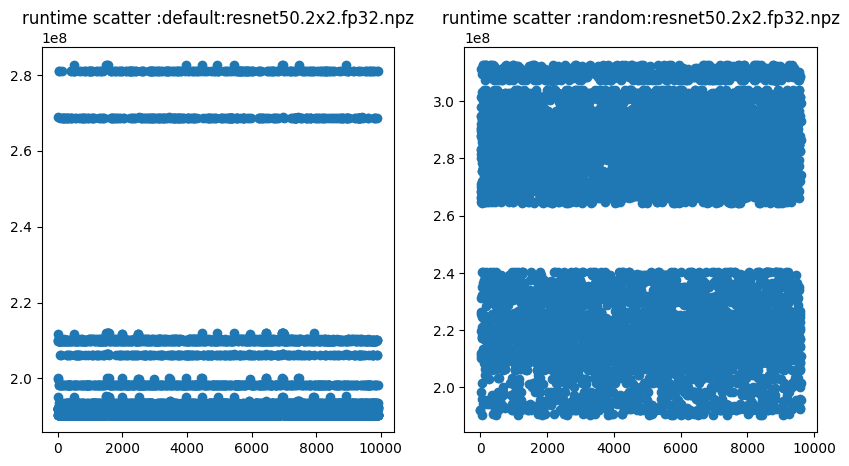

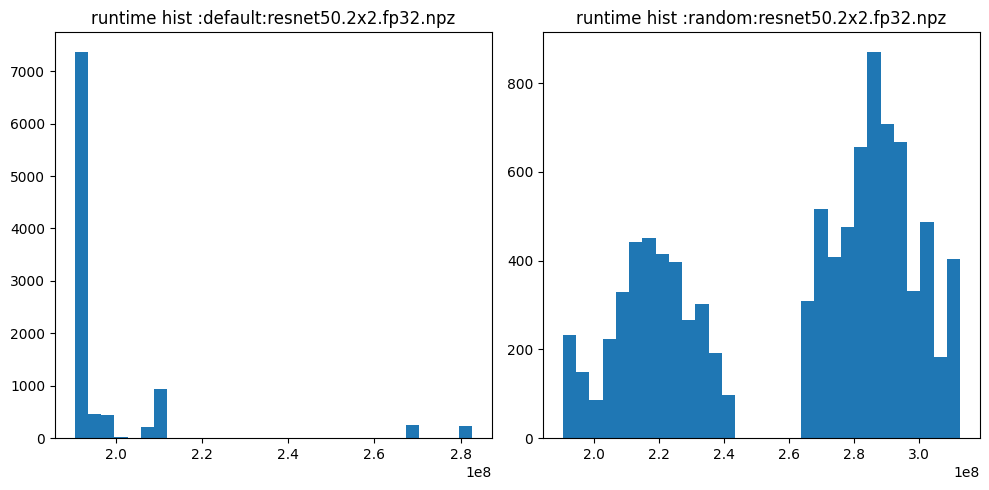

In [3]:
mname = df[(df.modeltype=="xla")&(df.graphtype=="layout")&(df.split=="train")].modelname.sample(1).to_list()[0]
pths = df[(df.modeltype=="xla")&(df.graphtype=="layout")&(df.split=="train")&(df.modelname==mname)].path.to_list()
conftype = df[(df.modeltype=="xla")&(df.graphtype=="layout")&(df.split=="train")&(df.modelname==mname)].config_type.to_list()
if len(pths)==2:
    fig, axs = plt.subplots(1, 2,figsize=(10, 5)) # 1 row, 2 columns
    fig1, axs1 = plt.subplots(1, 2,figsize=(10, 5)) # 1 row, 2 columns
    for i,(p,ct) in enumerate(zip(pths,conftype)):
        info = dict(np.load(p))

        x = np.arange(len(info["config_runtime"]))
        y = info["config_runtime"]
        axs[i].scatter(x,y)
        axs[i].set_title(f"runtime scatter :{ct}:{mname}")
        # Second plot
        axs1[i].hist(y,bins=30)
        axs1[i].set_title(f"runtime hist :{ct}:{mname}")

    plt.tight_layout() # Adjust the layout so the plots are nicely fit
    plt.show


In [3]:
opcodes = json.load(open("/app/nn-runtime-network/assets/opt_code.json"))

In [11]:
files = np.random.choice(glob.glob("/app/dataset/various_splits/all_layout/train/*"),2)
# files = glob.glob("/app/dataset/various_splits/all_layout/test/*")


In [12]:
from torch.utils.data import DataLoader
from configs.listmle_gsage_bestparams import Configs
CFG = Configs()

length of train: 529, length of valid: 54, length of test: 44


In [13]:
data = []
for d in tqdm(files):
    data.append(dict(np.load(d)))

100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


In [14]:
info = data[1] 

In [15]:
mask = info["node_feat"][:,21:27]<1
info["node_feat"][:,134:][mask] = -1
indices = np.where(~mask)
new_feat = -1 * np.ones_like(info["node_feat"][:,21:27])
dimensions = info["node_feat"][:,134:][indices[0],indices[1]].astype(int)
new_feat[indices[0],dimensions] = info["node_feat"][:,21:27][indices[0],dimensions]
info["node_feat"] = np.concatenate([info["node_feat"],new_feat],axis=1)

indices = np.where(info["node_config_feat"][:,:,0:6]!=-1)
new_feat = -1 * np.ones_like(info["node_config_feat"][:,:,0:6])
dims = info["node_config_feat"][:,:,0:6][indices[0],indices[1],indices[2]].astype(int)

new_feat[indices[0],indices[1],indices[2]] = info["node_feat"][:,21:27][info["node_config_ids"][indices[1]],dims]
info["node_config_feat"] = np.concatenate([info["node_config_feat"],new_feat],axis=2)

In [16]:
mask = info["node_config_feat"][:,:,0:6]!=-1
print(info["node_config_feat"][:,:,0:6][mask.sum(2)>0].astype(int))
print("========================")
print(info["node_config_feat"][:,:,-6:][mask.sum(2)>0].astype(int))
print("========================")
print(info["node_feat"][info["node_config_ids"][np.where(mask.sum(2)>0)[1]],21:27].astype(int))

[[ 1  0 -1 -1 -1 -1]
 [ 1  3 -1 -1 -1 -1]
 [ 1  3 -1 -1 -1 -1]
 ...
 [ 0 -1 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1 -1]]
[[ 512 2048   -1   -1   -1   -1]
 [ 128   64   -1   -1   -1   -1]
 [ 128   64   -1   -1   -1   -1]
 ...
 [   2   -1   -1   -1   -1   -1]
 [   2   -1   -1   -1   -1   -1]
 [   2   -1   -1   -1   -1   -1]]
[[2048  512    0    0    0    0]
 [  16  128    8   64    0    0]
 [  16  128    8   64    0    0]
 ...
 [   2    0    0    0    0    0]
 [   2    0    0    0    0    0]
 [   2    0    0    0    0    0]]


In [17]:
print(info["node_feat"][info["node_config_ids"],21:27].astype(int))

[[   0    0    0    0    0    0]
 [2048    0    0    0    0    0]
 [  16  128  512    0    0    0]
 [ 128  512    0    0    0    0]
 [2048    0    0    0    0    0]
 [2048  512    0    0    0    0]
 [  16  128  512    0    0    0]
 [2048  512    0    0    0    0]
 [2048  512    0    0    0    0]
 [2048  512    0    0    0    0]
 [  16  128    0    0    0    0]
 [  16  128    0    0    0    0]
 [  16  128    8   64    0    0]
 [  16  128    8   64    0    0]
 [  16    8  128  128    0    0]
 [  16  128    8   64    0    0]
 [  16    8  128   64    0    0]
 [  16  128  512    0    0    0]
 [  16  128 2048    0    0    0]
 [  16  128  512    0    0    0]
 [  16  128    8   64    0    0]
 [  16  128    8   64    0    0]
 [  16    8  128  128    0    0]
 [  16  128    8   64    0    0]
 [  16    8  128   64    0    0]
 [  16  128  512    0    0    0]
 [  16  128 2048    0    0    0]
 [  16  128  512    0    0    0]
 [  16  128    8   64    0    0]
 [  16  128    8   64    0    0]
 [  16    

In [18]:
info["node_feat"][(mask.sum(1)>0),134:].astype(int)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [56]:
info["node_feat"][(mask.sum(1)>0),21:27].astype(int)

array([[30522,   768,     0,     0,     0,     0],
       [ 2048,     0,     0,     0,     0,     0],
       [ 2048,     0,     0,     0,     0,     0],
       ...,
       [   16,     2,     0,     0,     0,     0],
       [   16,     0,     0,     0,     0,     0],
       [   16,     0,     0,     0,     0,     0]])

In [57]:
info["node_feat"][(mask.sum(1)>0),140:].astype(int)

array([[30522,   768,    -1,    -1,    -1,    -1],
       [ 2048,    -1,    -1,    -1,    -1,    -1],
       [ 2048,    -1,    -1,    -1,    -1,    -1],
       ...,
       [   16,     2,    -1,    -1,    -1,    -1],
       [   16,    -1,    -1,    -1,    -1,    -1],
       [   16,    -1,    -1,    -1,    -1,    -1]])

In [8]:
node_feats = np.concatenate([d["node_feat"] for d in data],0)
config_feats = np.concatenate([d["node_config_feat"].reshape(-1,18) for d in data],0)

In [9]:
condition_indices = np.where(CFG.train_dataset.node_feat_norms[2][0] > 5)[0]

# Filter the columns of node_feats based on these indices
filtered_node_feats = node_feats[:, condition_indices]


In [ ]:
nodefeat_names = json.load(open("/app/nn-runtime-network/assets/node_feature_vector.json"))
for i in tqdm(range(140)):
    nodefeat_names[str(i)] = np.unique(node_feats[:,i],axis=0)

In [ ]:
CATEGORICAL = [k for k,v in nodefeat_names.items() if len(v)<5]
CONTINUOUS = [k for k,v in nodefeat_names.items() if k not in CATEGORICAL]

In [ ]:
info = nodefeat_names[CONTINUOUS[11]]
plt.scatter(np.arange(len(info)),info)

In [ ]:
plt.hist([len(s["config_runtime"]) for s in data],bins=50)
plt.title(f"Histogram of number of configs")
plt.show()

In [ ]:
runtimes = [d["config_runtime"] for d in data]

In [ ]:
# Sample 8 of them
sampled_runtimes = np.random.choice(np.arange(len(runtimes)), 8, replace=False)

# Create a grid of scatter plots
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for ax, runtime in zip(axes.ravel(), sampled_runtimes):
    # Assuming runtimes are 1D arrays, we scatter them against their indices
    ax.scatter(range(len(runtimes[runtime])), runtimes[runtime])
    ax.set_xlabel("Index")
    ax.set_ylabel("Runtime Value")

plt.tight_layout()
plt.show()


In [ ]:
nodeops_with_configs = np.concatenate([d["node_opcode"][d["node_config_ids"]] for d in data])

In [ ]:
number_nodes = [d["node_opcode"].shape[0] for d in data]


In [ ]:
plt.scatter(np.arange(len(number_nodes)),number_nodes)
plt.title("Number of nodes in a graph")

In [ ]:
# Count unique values
unique_values, counts = np.unique(nodeops_with_configs, return_counts=True)
print([opcodes[str(i)] for i in unique_values],unique_values)
# Plot bar plot
plt.bar(unique_values, counts)
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Which opcodes have configurations values')
plt.show()

In [ ]:
unique_values

In [ ]:
# Count unique values
unique_values, counts = np.unique(np.concatenate([d["node_opcode"] for d in data]), return_counts=True)
print(len(unique_values),[opcodes[str(i)] for i in unique_values],unique_values)
# Plot bar plot
plt.bar(unique_values, counts)
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Which opcodes have configurations values')
plt.show()

In [ ]:
import networkx as nx
import numpy as np

def graph_stats(edges_array):
    # Create a directed graph from the edges array
    G = nx.from_edgelist(edges_array, create_using=nx.DiGraph())
    
    # Calculate maximum in-degree
    in_degrees = dict(G.in_degree())
    max_in_degree = max(in_degrees.values()) if in_degrees else 0
    average_in_degree = np.mean(list(in_degrees.values())) if in_degrees else 0
    median_in_degree = np.median(list(in_degrees.values())) if in_degrees else 0


    # Calculate maximum out-degree
    out_degrees = dict(G.out_degree())
    max_out_degree = max(out_degrees.values()) if out_degrees else 0
    average_out_degree = np.mean(list(out_degrees.values())) if in_degrees else 0
    median_out_degree = np.median(list(out_degrees.values())) if in_degrees else 0

    # Calculate number of strongly connected components
    G = nx.from_edgelist(edges_array, create_using=nx.Graph())
    # (For directed graphs, we should consider strongly connected components)
    num_connected_components = len(list(nx.connected_components(G)))

    return {
        "max_in_degree": max_in_degree,
        "max_out_degree": max_out_degree,
        "average_in_degree": average_in_degree,
        "average_out_degree": average_out_degree,
        "median_in_degree": median_in_degree,
        "median_out_degree": median_out_degree,
        "num_connected_components": num_connected_components
    }

In [ ]:
stats = [graph_stats(d["edge_index"]) for d in tqdm(data)] 

In [ ]:
for k in stats[0]:
    plt.hist([s[k] for s in stats],bins=50)
    plt.title(f"Histogram of {k}")
    plt.show()

In [ ]:
import networkx as nx
import numpy as np

def connected_nodes_count(edges_array, sample_nodes_array,successor=False):
    # Create a directed graph from the edges array
    G = nx.from_edgelist(edges_array, create_using=nx.DiGraph())
    
    connected_nodes = set()
    
    for node in sample_nodes_array:
        # Add predecessors (incoming edges)
        connected_nodes.add(node.item())
        connected_nodes.update(G.predecessors(node))
        # Add successors (outgoing edges)
        if successor:
            connected_nodes.update(G.successors(node))

    # Remove sample nodes from the count, as we only want nodes connected to them
    # connected_nodes = connected_nodes - set(sample_nodes_array)

    return len(connected_nodes)

predecessor_nodes_ratio = [connected_nodes_count(d["edge_index"],d["node_config_ids"])/len(d["node_opcode"]) for d in tqdm(data)] 
direct_nodes_ratio = [connected_nodes_count(d["edge_index"],d["node_config_ids"],successor=True)/len(d["node_opcode"]) for d in tqdm(data)] 


In [ ]:
plt.hist(predecessor_nodes_ratio,bins=50)
plt.title("Histogram of ratio of predeceesors connected directly to config nodes")
plt.show()


plt.hist(direct_nodes_ratio,bins=50)
plt.title("Histogram of ratio of nodes connected directly to config nodes")
plt.show()